Imports

In [1]:
###IDEAS SOURCED FROM:
###https://towardsdatascience.com/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe
###https://towardsdatascience.com/the-most-important-data-science-tool-for-market-and-customer-segmentation-c9709ca0b64a

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import skewtest
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

Read in all tables and visualize.

In [3]:
aisles = pd.read_csv('aisles.csv')

departments = pd.read_csv('departments.csv')

order_products_prior = pd.read_csv('order_products__prior.csv')

order_products_train = pd.read_csv('order_products__train.csv')

orders = pd.read_csv('orders.csv')

products = pd.read_csv('products.csv')

In [4]:
###CREATE USER TOTAL ORDER COLUMN FOR CLUSTERING PURPOSE - CODE CHECK

orders.groupby(['user_id'])['order_id'].count()

user_id
1         11
2         15
3         13
4          6
5          5
          ..
206205     4
206206    68
206207    17
206208    50
206209    14
Name: order_id, Length: 206209, dtype: int64

In [5]:
###CREATE USER TOTAL ORDER COLUMN FOR CLUSTERING PURPOSE

orders['order_ct'] = orders.groupby(['user_id'])['order_id'].transform('nunique')

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_ct
0,2539329,1,prior,1,2,8,NaN,11
1,2398795,1,prior,2,3,7,15.0,11
2,473747,1,prior,3,3,12,21.0,11
3,2254736,1,prior,4,4,7,29.0,11
4,431534,1,prior,5,4,15,28.0,11


In [6]:
###CREATE USER AVERAGE NUMBER OF DAY OF ORDERS FOR CUSTOMERS - CODE CHECK

orders.groupby(["user_id"])['days_since_prior_order'].mean()

user_id
1         19.000000
2         16.285714
3         12.000000
4         17.000000
5         11.500000
            ...    
206205    16.666667
206206     3.716418
206207    14.312500
206208     7.367347
206209    18.461538
Name: days_since_prior_order, Length: 206209, dtype: float64

In [7]:
###CREATE USER AVERAGE NUMBER OF DAY OF ORDERS FOR CUSTOMERS

orders['order_avg_lag'] = orders.groupby(["user_id"])['days_since_prior_order'].transform('mean')

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_ct,order_avg_lag
0,2539329,1,prior,1,2,8,NaN,11,19.0
1,2398795,1,prior,2,3,7,15.0,11,19.0
2,473747,1,prior,3,3,12,21.0,11,19.0
3,2254736,1,prior,4,4,7,29.0,11,19.0
4,431534,1,prior,5,4,15,28.0,11,19.0


In [8]:
### CREATE AVERAGE SIZE OF ORDER

###STEP 1 - COMBINE order_products_prior AND order_products_train

frames = [order_products_prior, order_products_train]

order_products_comb = pd.concat(frames)

order_products_comb.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
###CREATE AVERAGE SIZE OF ORDER CONTD

###COUNT UNIQUE PRODUCT ID PER ORDER

order_products_comb.groupby(['order_id'])['product_id'].count()

order_id
1           8
2           9
3           8
4          13
5          26
           ..
3421079     1
3421080     9
3421081     7
3421082     7
3421083    10
Name: product_id, Length: 3346083, dtype: int64

In [10]:
###CREATE AVERAGE SIZE OF ORDER CONTD

###STEP 2 - CREATE FIELD WITH COUNT UNIQUE PRODUCT ID PER ORDER

order_products_comb['order_size'] = order_products_comb.groupby(["order_id"])['product_id'].transform('nunique')
order_products_comb.head()

,order_id,product_id,add_to_cart_order,reordered,order_size
0,2,33120,1,1,9
1,2,28985,2,1,9
2,2,9327,3,0,9
3,2,45918,4,1,9
4,2,30035,5,0,9


In [11]:
###CREATE AVERAGE SIZE OF ORDER CONTD
###NEED TO RENAME COLUMNS FIRST SO IT WILL BE A CLEAN MERGE
### https://stackoverflow.com/questions/11346283/renaming-column-names-in-pandas

order_products_comb = order_products_comb.rename({'order_id':'order_id_2'},axis=1)
order_products_comb.head()

,order_id_2,product_id,add_to_cart_order,reordered,order_size
0,2,33120,1,1,9
1,2,28985,2,1,9
2,2,9327,3,0,9
3,2,45918,4,1,9
4,2,30035,5,0,9


In [12]:
###CREATE AVERAGE SIZE OF ORDER CONTD

###STEP 3 - MERGE ORDER SIZE INTO ORDER COLUMN [MERGE OF ORDERS AND ORDERS_PRODUCT_COMB AT THIS STEP]
###https://stackoverflow.com/questions/17978133/python-pandas-merge-only-certain-columns

orders = orders.merge(order_products_comb[['order_id_2', 'order_size', 'product_id', 'add_to_cart_order',
                                          'reordered']], how = 'left', left_on='order_id', 
                      right_on='order_id_2').drop(columns=['order_id_2'])

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_ct,order_avg_lag,order_size,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,196.0,1.0,0.0
1,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,14084.0,2.0,0.0
2,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,12427.0,3.0,0.0
3,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,26088.0,4.0,0.0
4,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,26405.0,5.0,0.0


In [13]:
###CREATE AVERAGE SIZE OF ORDER CONTD

###STEP 4 - GROUP BY USER_ID TO FIND AVG ORDER_SIZE - CODE CHECK

orders.groupby(["user_id"])['order_size'].mean()

user_id
1          7.000000
2         18.150442
3          7.886364
4          4.555556
5          9.826087
            ...    
206205    14.960784
206206     6.670175
206207    16.390135
206208    16.033973
206209    12.313869
Name: order_size, Length: 206209, dtype: float64

In [14]:
###CREATE AVERAGE SIZE OF ORDER CONTD

###STEP 4 - GROUP BY USER_ID TO FIND AVG ORDER_SIZE - CODE CHECK

orders['order_avg_size'] = orders.groupby(["user_id"])['order_size'].transform('mean')

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_ct,order_avg_lag,order_size,product_id,add_to_cart_order,reordered,order_avg_size
0,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,196.0,1.0,0.0,7.0
1,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,14084.0,2.0,0.0,7.0
2,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,12427.0,3.0,0.0,7.0
3,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,26088.0,4.0,0.0,7.0
4,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,26405.0,5.0,0.0,7.0


In [15]:
###Create category with time of day

def get_part_of_day(hour):
    
    if hour in [5, 6, 7, 8]:
        return "Early_Morning"
    
    elif hour in [9, 10, 11]:
        return "Late_Morning"
    
    elif hour in [12, 13, 14]:
        return "Early_Afternoon"
    
    elif hour in [15, 16, 17]:
        return "Late_Afternoon"
    
    elif hour in [18, 19, 20]:
        return "Early Evening"
    
    elif hour in [21, 22, 23]:
        return "Late Evening"
    
    elif hour in [0, 1, 2, 3, 4]:
        return "Night"
    
    
orders['part_of_day'] = orders['order_hour_of_day'].apply(get_part_of_day)

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_ct,order_avg_lag,order_size,product_id,add_to_cart_order,reordered,order_avg_size,part_of_day
0,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,196.0,1.0,0.0,7.0,Early_Morning
1,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,14084.0,2.0,0.0,7.0,Early_Morning
2,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,12427.0,3.0,0.0,7.0,Early_Morning
3,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,26088.0,4.0,0.0,7.0,Early_Morning
4,2539329,1,prior,1,2,8,NaN,11,19.0,5.0,26405.0,5.0,0.0,7.0,Early_Morning


In [16]:
###CREATE CLUSTER DATAFRAME BASED OFF OF TRAINING SET ONLY

cluster_df = orders[orders['eval_set']== 'train']
cluster_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_ct,order_avg_lag,order_size,product_id,add_to_cart_order,reordered,order_avg_size,part_of_day
59,1187899,1,train,11,4,8,14.0,11,19.0,11.0,196.0,1.0,1.0,7.0,Early_Morning
60,1187899,1,train,11,4,8,14.0,11,19.0,11.0,25133.0,2.0,1.0,7.0,Early_Morning
61,1187899,1,train,11,4,8,14.0,11,19.0,11.0,38928.0,3.0,1.0,7.0,Early_Morning
62,1187899,1,train,11,4,8,14.0,11,19.0,11.0,26405.0,4.0,1.0,7.0,Early_Morning
63,1187899,1,train,11,4,8,14.0,11,19.0,11.0,39657.0,5.0,1.0,7.0,Early_Morning


In [17]:
cluster_df.shape

(1384617, 15)

In [18]:
###DROPPING UNNECESSARY COLUMNS FOR ANALYSIS

cluster_df = cluster_df.drop(['order_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
                             'order_size', 'product_id', 'add_to_cart_order', 'reordered', 'part_of_day',
                             'order_avg_lag'], axis=1)
cluster_df.head()

,user_id,days_since_prior_order,order_ct,order_avg_size
59,1,14.0,11,7.0
60,1,14.0,11,7.0
61,1,14.0,11,7.0
62,1,14.0,11,7.0
63,1,14.0,11,7.0


In [19]:
###FILTERING FOR UNIQUE USERS

cluster_df = cluster_df.drop_duplicates(subset=['user_id'], keep='last')

cluster_df.head()

,user_id,days_since_prior_order,order_ct,order_avg_size
69,1,14.0,11,7.000000
295,2,30.0,15,18.150442
449,5,6.0,5,9.826087
679,7,6.0,21,13.316279
746,8,10.0,4,17.298507


In [21]:
###Rename Columns to RFM

cluster_df.rename(columns={'days_since_prior_order':'Recency','order_ct':'Frequency','order_avg_size':'MonetaryValue'}
                 , inplace=True)

cluster_df.set_index('user_id', inplace=True)

cluster_df.head()

,Recency,Frequency,MonetaryValue
user_id,,,
1,14.0,11,7.000000
2,30.0,15,18.150442
5,6.0,5,9.826087
7,6.0,21,13.316279
8,10.0,4,17.298507


In [22]:
###Check for Skewness in RFM

def skew_check(df, column):
    skewness = skew(df[column])
    skewcheck = skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{} Skew: {}, : {}".format(column, skewness, skewcheck))
    
    return

C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency Skew: 0.03853760682804987, : SkewtestResult(statistic=5.697110736025705, pvalue=1.2185478645636611e-08)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Frequency Skew: 2.3934781229481388, : SkewtestResult(statistic=216.9385678869659, pvalue=0.0)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MonetaryValue Skew: 1.118744706305434, : SkewtestResult(statistic=135.30603149132983, pvalue=0.0)


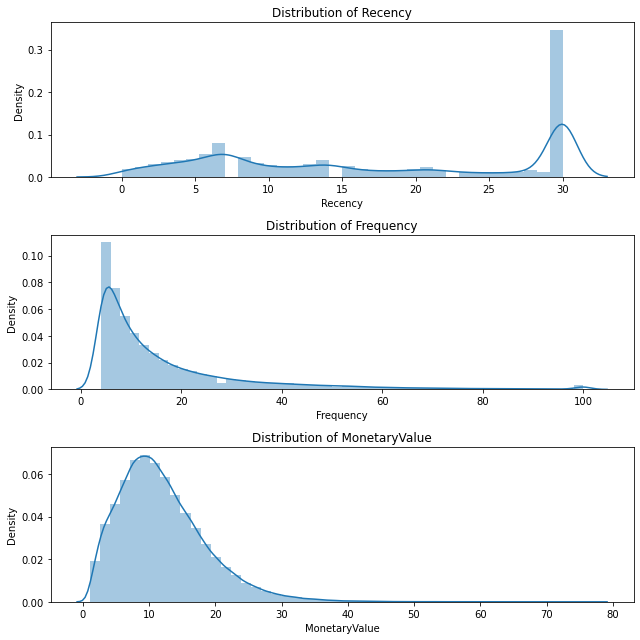

In [23]:
###Plotting Skewness

plt.figure(figsize=(9,9))

plt.subplot(3,1,1)
skew_check(cluster_df,'Recency')

plt.subplot(3,1,2)
skew_check(cluster_df,'Frequency')

plt.subplot(3,1,3)
skew_check(cluster_df,'MonetaryValue')

plt.tight_layout()


In [24]:
###DATA CHECK

cluster_df.describe()

,Recency,Frequency,MonetaryValue
count,131209.000000,131209.000000,131209.000000
mean,17.049859,16.603937,11.974192
std,10.676832,16.661077,6.627048
min,0.000000,4.000000,1.000000
25%,7.000000,6.000000,7.235294
50%,15.000000,10.000000,10.919799
75%,30.000000,20.000000,15.570447
max,30.000000,100.000000,77.265734


In [25]:
###LOG TRANSFORM TO REDUCE SKEWNESS ISSUE

cluster_log_df = cluster_df.copy()

In [26]:
###Added 1 to values to mitigate log(0) issues

cluster_log_df['Recency'] = cluster_log_df['Recency'] + 1

In [27]:
###RECENCY BEST TRANSFORM

recency_check = cluster_log_df.copy()

recency_check = recency_check.drop(['Frequency', 'MonetaryValue'], axis=1)

recency_check['recency_log'] = np.log(recency_check['Recency'])
recency_check['recency_square'] = np.square(recency_check['Recency'])
recency_check['recency_cube'] = np.cbrt(recency_check['Recency'])


In [28]:
recency_check.head()

,Recency,recency_log,recency_square,recency_cube
user_id,,,,
1,15.0,2.708050,225.0,2.466212
2,31.0,3.433987,961.0,3.141381
5,7.0,1.945910,49.0,1.912931
7,7.0,1.945910,49.0,1.912931
8,11.0,2.397895,121.0,2.223980


In [29]:
recency_check.describe()

,Recency,recency_log,recency_square,recency_cube
count,131209.000000,131209.000000,131209.000000,131209.000000
mean,18.049859,2.634724,439.791295,2.489970
std,10.676832,0.816963,396.607754,0.602363
min,1.000000,0.000000,1.000000,1.000000
25%,8.000000,2.079442,64.000000,2.000000
50%,16.000000,2.772589,256.000000,2.519842
75%,31.000000,3.433987,961.000000,3.141381
max,31.000000,3.433987,961.000000,3.141381


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency Skew: 0.03853760682804987, : SkewtestResult(statistic=5.697110736025705, pvalue=1.2185478645636611e-08)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


recency_log Skew: -0.9381079299727046, : SkewtestResult(statistic=-118.68371636918536, pvalue=0.0)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


recency_square Skew: 0.34116242568340344, : SkewtestResult(statistic=49.090342621021904, pvalue=0.0)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


recency_cube Skew: -0.44934872268570764, : SkewtestResult(statistic=-63.48766893278244, pvalue=0.0)


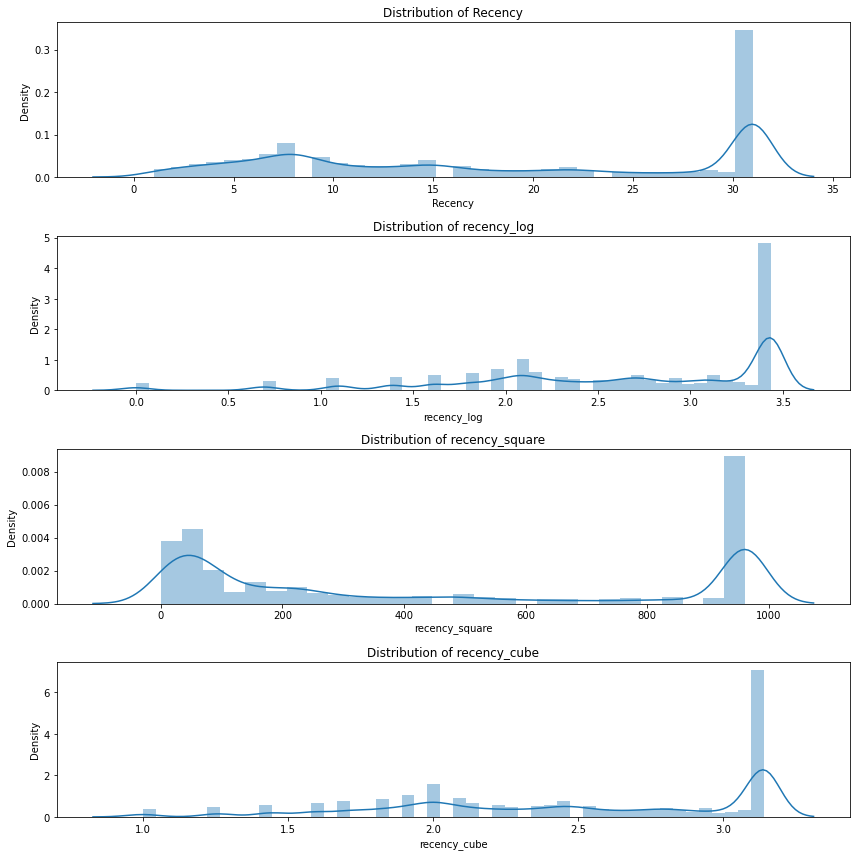

In [30]:
###Recency Skewness Check

plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
skew_check(recency_check,'Recency')

plt.subplot(4,1,2)
skew_check(recency_check,'recency_log')

plt.subplot(4,1,3)
skew_check(recency_check,'recency_square')

plt.subplot(4,1,4)
skew_check(recency_check,'recency_cube')

plt.tight_layout()

In [31]:
###LOG TRANSFORM ON FREQUENCY AND MONETARY VALUE TO REDUCE SKEWNESS ISSUE


cluster_log_df['Frequency'] = np.log(cluster_log_df['Frequency'])
cluster_log_df['MonetaryValue'] = np.log(cluster_log_df['MonetaryValue'])

cluster_log_df.head()

,Recency,Frequency,MonetaryValue
user_id,,,
1,15.0,2.397895,1.945910
2,31.0,2.708050,2.898695
5,7.0,1.609438,2.285041
7,7.0,3.044522,2.588987
8,11.0,1.386294,2.850620


In [32]:
cluster_log_df.describe()

,Recency,Frequency,MonetaryValue
count,131209.000000,131209.000000,131209.000000
mean,18.049859,2.454702,2.316415
std,10.676832,0.801848,0.615706
min,1.000000,1.386294,0.000000
25%,8.000000,1.791759,1.978971
50%,16.000000,2.302585,2.390578
75%,31.000000,2.995732,2.745375
max,31.000000,4.605170,4.347251


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency Skew: 0.03853760682804987, : SkewtestResult(statistic=5.697110736025705, pvalue=1.2185478645636611e-08)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Frequency Skew: 0.5541023718876904, : SkewtestResult(statistic=76.68576395568466, pvalue=0.0)


C:\Users\holac\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MonetaryValue Skew: -0.6979622825171968, : SkewtestResult(statistic=-93.5712946197366, pvalue=0.0)


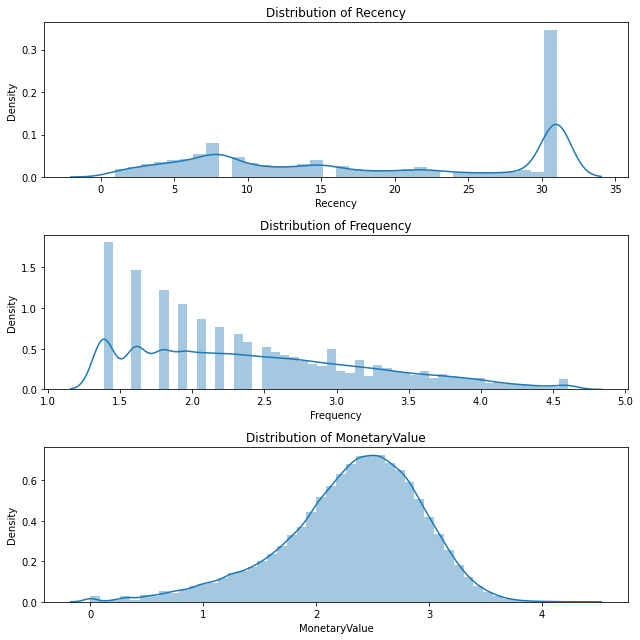

In [33]:
###Post Transform Skewness Check

plt.figure(figsize=(9,9))

plt.subplot(3,1,1)
skew_check(cluster_log_df,'Recency')

plt.subplot(3,1,2)
skew_check(cluster_log_df,'Frequency')

plt.subplot(3,1,3)
skew_check(cluster_log_df,'MonetaryValue')

plt.tight_layout()

In [34]:
###SCALE AND CENTER DATA

scaler = StandardScaler()
scaler.fit(cluster_log_df)
cluster_df_normal = scaler.transform(cluster_log_df)

cluster_df_normal = pd.DataFrame(cluster_df_normal, index=cluster_log_df.index, columns=cluster_log_df.columns)

cluster_df_normal.describe().round(3)

,Recency,Frequency,MonetaryValue
count,131209.000,131209.000,131209.000
mean,0.000,0.000,0.000
std,1.000,1.000,1.000
min,-1.597,-1.332,-3.762
25%,-0.941,-0.827,-0.548
50%,-0.192,-0.190,0.120
75%,1.213,0.675,0.697
max,1.213,2.682,3.298


In [37]:
###FUNCTION FIND OPTIMAL NUMBER OF CLUSTERS

def optimal_kmeans(dataset, start=2, end=11):

    ###Value Storage for Graph Plotting
    num_clusters = []
    km_ss = []
    inertia = []
    
    ###Find Optimal Number of Clusters
    for nc in range(start,end):
        
        ###cluster label creation
        kmeans = KMeans(n_clusters = nc)
        labels = kmeans.fit_predict(dataset)
        
        ###model performance calculation
        silhouette_avg = round(silhouette_score(dataset, labels, random_state=1), 3)
        inertia_score = round(kmeans.inertia_, 2)
        
        ##append scores
        num_clusters.append(nc)
        km_ss.append(silhouette_avg)
        inertia.append(inertia_score)
        
        print("No. Clusters: {}, Silhouette Score(SS): {}, SS Delta: {}, Inertia: {}, Inertia Delta: {}".format(
            num_clusters, 
            silhouette_avg, 
            (km_ss[nc - start] - km_ss[nc - start - 1]).round(3), 
            inertia_score, 
            (inertia[nc - start] - inertia[nc - start - 1])))
        
        # Plot graph at the end of loop
        if nc == end - 1:
            plt.figure(figsize=(9,6))

            plt.subplot(2, 1, 1)
            plt.title('Within-Cluster Sum-of-Squares / Inertia')
            sns.pointplot(x=num_clusters, y=inertia)

            plt.subplot(2, 1, 2)
            plt.title('Silhouette Score')
            sns.pointplot(x=num_clusters, y=km_ss)
            plt.tight_layout()
            plt.show()       
        
        

No. Clusters: [2], Silhouette Score(SS): 0.326, SS Delta: 0.0, Inertia: 259804.64, Inertia Delta: 0.0
No. Clusters: [2, 3], Silhouette Score(SS): 0.312, SS Delta: -0.014, Inertia: 200770.28, Inertia Delta: -59034.360000000015
No. Clusters: [2, 3, 4], Silhouette Score(SS): 0.324, SS Delta: 0.012, Inertia: 153762.62, Inertia Delta: -47007.66
No. Clusters: [2, 3, 4, 5], Silhouette Score(SS): 0.309, SS Delta: -0.015, Inertia: 133318.46, Inertia Delta: -20444.160000000003
No. Clusters: [2, 3, 4, 5, 6], Silhouette Score(SS): 0.307, SS Delta: -0.002, Inertia: 116612.84, Inertia Delta: -16705.619999999995
No. Clusters: [2, 3, 4, 5, 6, 7], Silhouette Score(SS): 0.291, SS Delta: -0.016, Inertia: 105208.49, Inertia Delta: -11404.349999999991
No. Clusters: [2, 3, 4, 5, 6, 7, 8], Silhouette Score(SS): 0.281, SS Delta: -0.01, Inertia: 95151.42, Inertia Delta: -10057.070000000007
No. Clusters: [2, 3, 4, 5, 6, 7, 8, 9], Silhouette Score(SS): 0.276, SS Delta: -0.005, Inertia: 86861.95, Inertia Delta: -

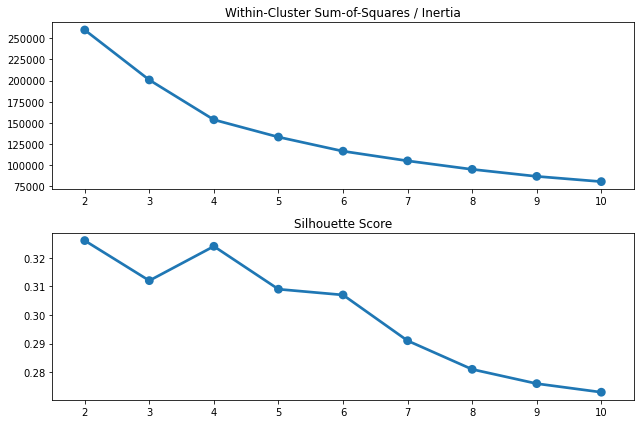

In [38]:
optimal_kmeans(cluster_df_normal)

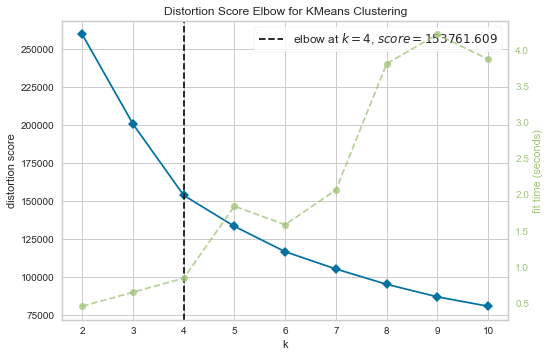

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
###ALTERNATE ELBOW PLOT

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,11))

visualizer.fit(cluster_df_normal)
visualizer.show()

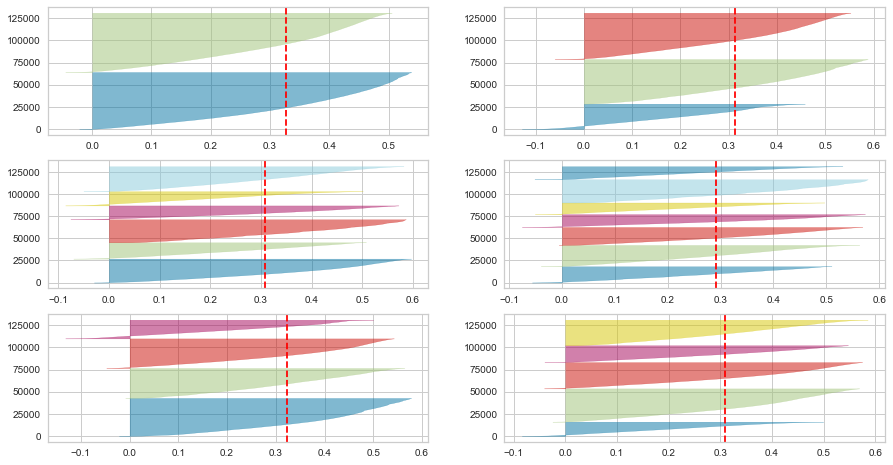

In [44]:
###ALTERNATE SILHOUETTE VISUALIZATION

fig, ax = plt.subplots(3, 2, figsize=(15,8))

for i in [2,3,4,5,6,7]:
    
    km2 = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i,2)
    
    visualizer2 = SilhouetteVisualizer(km2, colors='yellowbrick', ax=ax[1-q][mod])
    visualizer2.fit(cluster_df_normal)

In [45]:
###KMEANS FUNCTION

def kmeans(normalized_df, num_clusters, original_df):
    
    kmeans = KMeans(n_clusters = num_clusters, random_state = 1)
    kmeans.fit(normalized_df)
    
    ##Extract labels
    cluster_labels = kmeans.labels_
    
    ##add cluster label column to original dataset
    df_with_labels = original_df.assign(cluster = cluster_labels)
    
    ##TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_with_labels)
    
    ##Plotting TSNE
    plt.title("Flattened Graph of {} Clusters".format(num_clusters))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette='Set1')
    
    return df_with_labels
    
    
    

C:\Users\holac\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\holac\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\holac\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\holac\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\holac\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\holac\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: Future

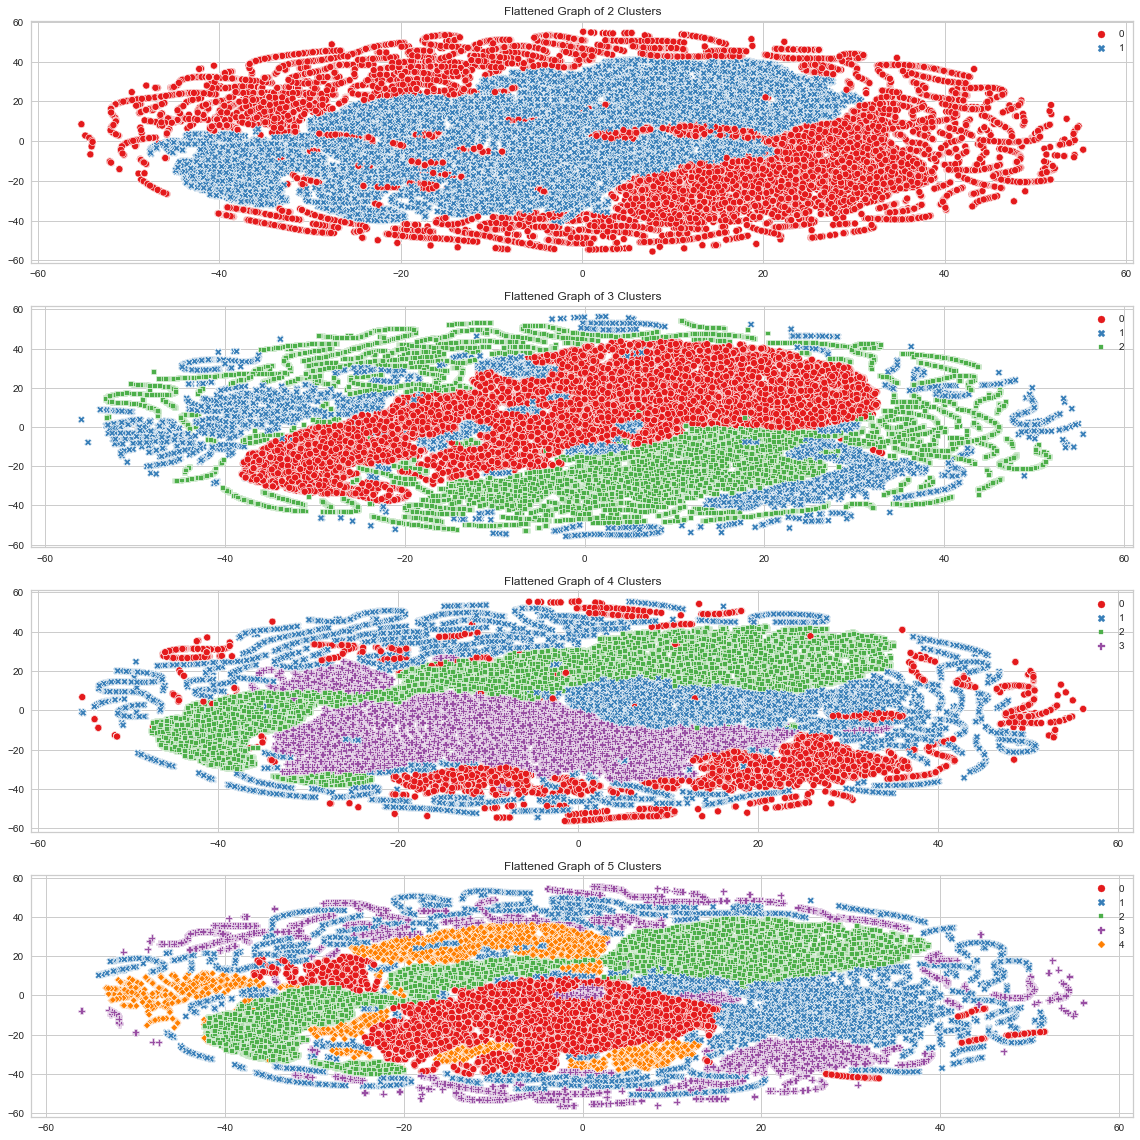

In [48]:
###TSNE PLOTS

plt.figure(figsize=(16, 16))

plt.subplot(4, 1, 1)
df_cluster_k2 = kmeans(cluster_df_normal, 2, cluster_df)

plt.subplot(4, 1, 2)
df_cluster_k3 = kmeans(cluster_df_normal, 3, cluster_df)

plt.subplot(4, 1, 3)
df_cluster_k4 = kmeans(cluster_df_normal, 4, cluster_df)

plt.subplot(4, 1, 4)
df_cluster_k5 = kmeans(cluster_df_normal, 5, cluster_df)


plt.tight_layout()



In [53]:
###SUMMARY STATS FUNCTION

def rfm_summary(df):
    df_new = df.groupby(['cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count']
    }).round(0)
    
    return df_new

In [55]:
rfm_summary(df_cluster_k2)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
cluster                                       
0          26.0       9.0          11.0  64635
1           8.0      24.0          13.0  66574

In [56]:
rfm_summary(df_cluster_k3)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
cluster                                       
0           8.0      27.0          13.0  53173
1          19.0       9.0           5.0  28013
2          26.0       9.0          14.0  50023

In [57]:
rfm_summary(df_cluster_k4)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
cluster                                       
0          22.0      10.0           4.0  21201
1          28.0      10.0          14.0  42792
2           8.0      38.0          13.0  33467
3           9.0       9.0          13.0  33749

In [58]:
rfm_summary(df_cluster_k5)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
cluster                                       
0           9.0       9.0          15.0  28825
1          28.0      10.0          15.0  37515
2           8.0      39.0          14.0  29817
3          28.0       8.0           5.0  18838
4           9.0      14.0           5.0  16214

In [59]:
###SNAKEPLOT FUNCTION

def snake_plot(normalised_df, df_kmeans, df_original):
    # Transform df_normal as df and add cluster column
    normalised_df = pd.DataFrame(normalised_df, 
                                       index=df_original.index, 
                                       columns=df_original.columns)
    normalised_df['cluster'] = df_kmeans['cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df.reset_index(), 
                        id_vars=['user_id', 'cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='cluster')
    
    return

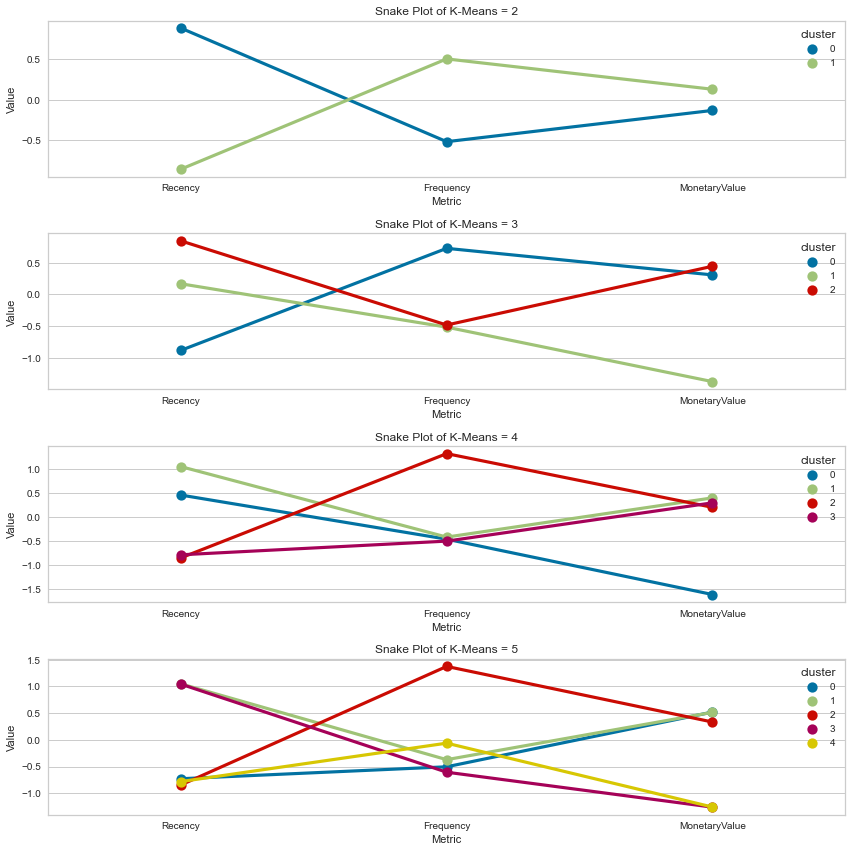

In [60]:
###PLOTTING SNAKEPLOTS

plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 2')
snake_plot(cluster_df_normal, df_cluster_k2, cluster_df)

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 3')
snake_plot(cluster_df_normal, df_cluster_k3, cluster_df)

plt.subplot(4, 1, 3)
plt.title('Snake Plot of K-Means = 4')
snake_plot(cluster_df_normal, df_cluster_k4, cluster_df)

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 5')
snake_plot(cluster_df_normal, df_cluster_k5, cluster_df)

plt.tight_layout()



In [63]:
###RELATIVE IMPORTANCE FUNCTION

def relative_importance(df_kmeans, df_original):
    # Calculate average RFM values for each cluster
    cluster_avg = df_kmeans.groupby(['cluster']).mean() 

    # Calculate average RFM values for the total customer population
    population_avg = df_original.mean()

    # Calculate relative importance of cluster's attribute value compared to population
    relative_imp = cluster_avg / population_avg - 1

    sns.heatmap(data=relative_imp, annot=True, fmt='.2f')
    
    return



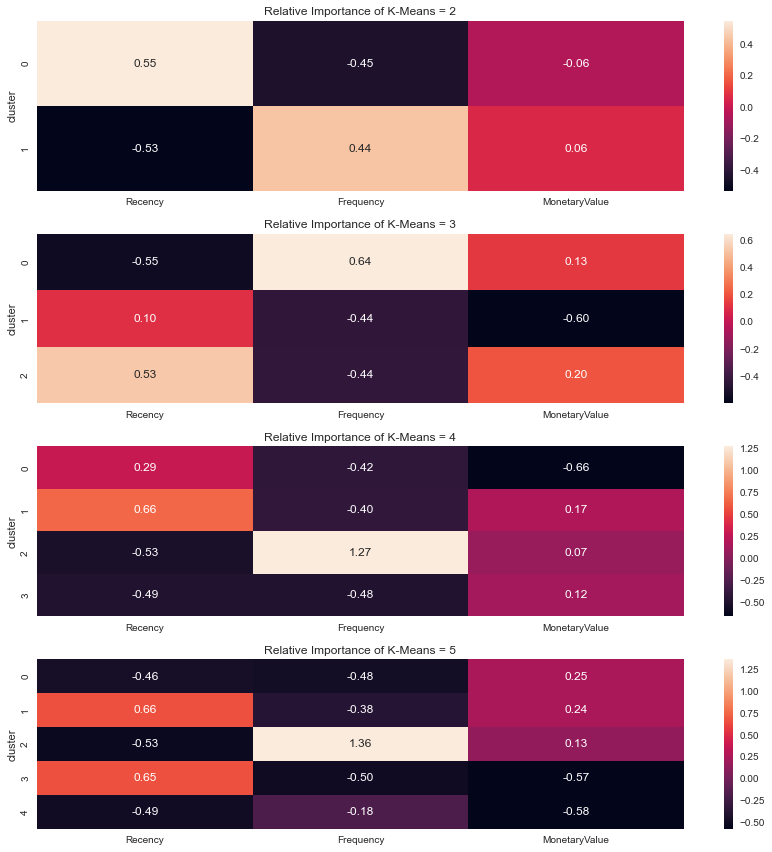

In [66]:
###PLOT RELATIVE IMPORTANCE

plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.title('Relative Importance of K-Means = 2')
relative_importance(df_cluster_k2, cluster_df)

plt.subplot(4, 1, 2)
plt.title('Relative Importance of K-Means = 3')
relative_importance(df_cluster_k3, cluster_df)

plt.subplot(4, 1, 3)
plt.title('Relative Importance of K-Means = 4')
relative_importance(df_cluster_k4, cluster_df)

plt.subplot(4, 1, 4)
plt.title('Relative Importance of K-Means = 5')
relative_importance(df_cluster_k5, cluster_df)

plt.tight_layout()

